<a href="https://colab.research.google.com/github/SongZhou-Meg/shap/blob/master/LLM_and_customer_segmentation_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let’s see 3 methods to approach this type of project:

method 1: Kmeans



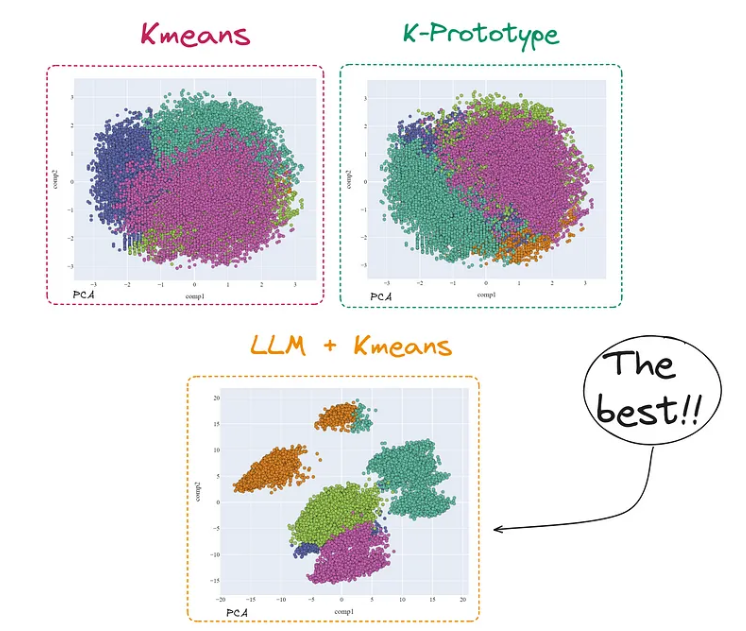

In [1]:
!pip install shap
!pip install pyod
!pip install prince

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185329 sha256=d2e3759495a7f554190e0ee09dd160c81044c146ef5ab6afc7f7c040d975406e
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.1/415.1 kB 4.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# read data
data_path1 = '/content/drive/MyDrive/Data/LLM_cust_sege/train.csv'
df = pd.read_csv(data_path1, sep=';')
df = df.iloc[:, 0:8]

pipe = Pipeline([('ordinal', OrdinalEncoder()), ('scaler', PowerTransformer())])
pipe_fit = pipe.fit(df)

data = pd.DataFrame(pipe_fit.transform(df), columns = df.columns)
data

age       job   marital  education  default   balance   housing  \
0      1.469546  0.093094 -0.286301   1.029751 -0.13549  0.996466  0.893915   
1      0.417051  1.277591  1.379481  -0.254415 -0.13549 -0.775508  0.893915   
2     -0.693452 -0.579713 -0.286301  -0.254415 -0.13549 -0.818578  0.893915   
3      0.667539 -1.017980 -0.286301   2.201328 -0.13549  0.646343  0.893915   
4     -0.693452  1.652351  1.379481   2.201328 -0.13549 -0.820196 -1.118674   
...         ...       ...       ...        ...      ...       ...       ...   
45206  0.977930  1.277591 -0.286301   1.029751 -0.13549  0.142935 -1.118674   
45207  2.256815  0.371310 -1.892104  -1.734294 -0.13549  0.779764 -1.118674   
45208  2.312138  0.371310 -0.286301  -0.254415 -0.13549  1.914392 -1.118674   
45209  1.402760 -1.017980 -0.286301  -0.254415 -0.13549 -0.000442 -1.118674   
45210 -0.245723 -0.579713 -0.286301  -0.254415 -0.13549  1.337156 -1.118674   

           loan  
0     -0.436803  
1     -0.436803  
2      2.289359  
3     -0.436803  
4     -0.436803  
...         ...  
45206 -0.436803  
45207 -0.436803  
45208 -0.436803  
45209 -0.436803  
45210 -0.436803  

[45211 rows x 8 columns]

get rid of outliers

In [5]:
from pyod.models.ecod import ECOD

clf = ECOD()
clf.fit(data)
outliers = clf.predict(data)

data["outliers"] = outliers

# Data without outliers
data_no_outliers = data[data["outliers"] == 0]
data_no_outliers = data_no_outliers.drop(["outliers"], axis = 1)

# Data with Outliers
data_with_outliers = data.copy()
data_with_outliers = data_with_outliers.drop(["outliers"], axis = 1)

print(data_no_outliers.shape)
print(data_with_outliers.shape)

(40691, 8)
(45211, 8)


Modeling


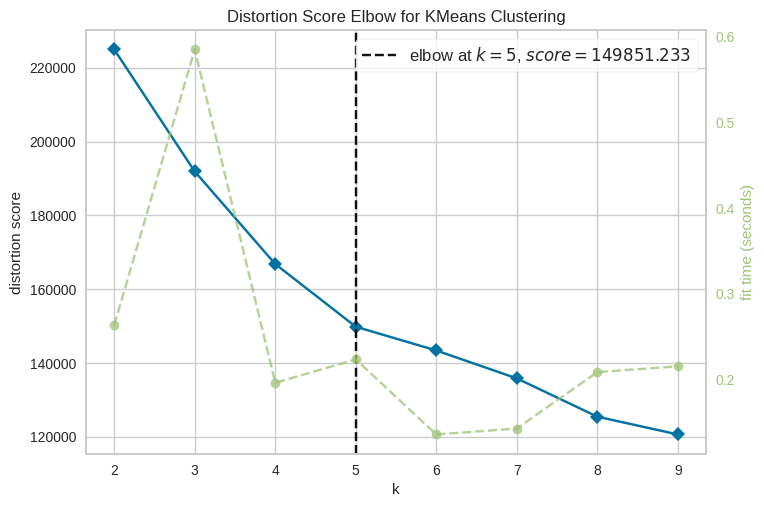

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10))

visualizer.fit(data_no_outliers)        # Fit the data to the visualizer
visualizer.show()

Silhoutte visualization

In [7]:
from sklearn.metrics import davies_bouldin_score, silhouette_score, silhouette_samples
import matplotlib.cm as cm

def make_Silhouette_plot(X, n_clusters):
    plt.xlim([-0.1, 1])
    plt.ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, max_iter = 1000, n_init = 10, init = 'k-means++', random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg,
    )
# Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
        plt.title(f"The Silhouette Plot for n_cluster = {n_clusters}", fontsize=26)
        plt.xlabel("The silhouette coefficient values", fontsize=24)
        plt.ylabel("Cluster label", fontsize=24)
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
        plt.yticks([])
        plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])



range_n_clusters = list(range(2,10))

for n_clusters in range_n_clusters:
    print(f"N cluster: {n_clusters}")
    make_Silhouette_plot(data_no_outliers, n_clusters)
    plt.savefig('Silhouette_plot_{}.png'.format(n_clusters))
    plt.close()




N cluster: 2
For n_clusters = 2 The average silhouette_score is : 0.17757615203713667
N cluster: 3
For n_clusters = 3 The average silhouette_score is : 0.20772622268949054
N cluster: 4
For n_clusters = 4 The average silhouette_score is : 0.20381164709323465
N cluster: 5
For n_clusters = 5 The average silhouette_score is : 0.2013910658188125
N cluster: 6
For n_clusters = 6 The average silhouette_score is : 0.2064701472282156
N cluster: 7
For n_clusters = 7 The average silhouette_score is : 0.21191547946062095
N cluster: 8
For n_clusters = 8 The average silhouette_score is : 0.208652716964872
N cluster: 9
For n_clusters = 9 The average silhouette_score is : 0.220484250710912


Creat Kmeans model with K=5

In [8]:
km = KMeans(n_clusters=5,
            init='k-means++',
            n_init=10,
            max_iter=100,
            random_state=42)

clusters_predict = km.fit_predict(data_no_outliers)


Evaluation

In [9]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

"""
The Davies Bouldin index is defined as the average similarity measure
of each cluster with its most similar cluster, where similarity
is the ratio of within-cluster distances to between-cluster distances.

The minimum value of the DB Index is 0, whereas a smaller
value (closer to 0) represents a better model that produces better clusters.
"""
print(f"Davies bouldin score: {davies_bouldin_score(data_no_outliers,clusters_predict)}")

"""
Calinski Harabaz Index -> Variance Ratio Criterion.

Calinski Harabaz Index is defined as the ratio of the
sum of between-cluster dispersion and of within-cluster dispersion.

The higher the index the more separable the clusters.
"""
print(f"Calinski Score: {calinski_harabasz_score(data_no_outliers,clusters_predict)}")


"""
The silhouette score is a metric used to calculate the goodness of
fit of a clustering algorithm, but can also be used as
a method for determining an optimal value of k (see here for more).

Its value ranges from -1 to 1.
A value of 0 indicates clusters are overlapping and either
the data or the value of k is incorrect.

1 is the ideal value and indicates that clusters are very
dense and nicely separated.
"""
print(f"Silhouette Score: {silhouette_score(data_no_outliers,clusters_predict)}")


Davies bouldin score: 1.5477805774321418
Calinski Score: 7646.949287373308
Silhouette Score: 0.20143615878846158


We do not have an excessively good model. Davies’ score is telling us that the distance between clusters is quite small.

Use Prince Libary

In [10]:
import prince
import plotly.express as px


def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter_3d(
          df,
          x='comp1',
          y='comp2',
          z='comp3',
          color='cluster',
          template="plotly",

          # symbol = "cluster",

          color_discrete_sequence=px.colors.qualitative.Vivid,
          title=title).update_traces(
              # mode = 'markers',
              marker={
                  "size": 4,
                  "opacity": opacity,
                  # "symbol" : "diamond",
                  "line": {
                      "width": width_line,
                      "color": "black",
                  }
              }
          ).update_layout(
                  width = 800,
                  height = 800,
                  autosize = True,
                  showlegend = True,
                  legend=dict(title_font_family="Times New Roman",
                              font=dict(size= 20)),
                  scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                              yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                              zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                  font = dict(family = "Gilroy", color  = 'black', size = 15))


    fig.show()

In [11]:
def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter(df,
                        x='comp1',
                        y='comp2',
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",

                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800,
                                height = 700,
                                autosize = False,
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))


    fig.show()

PCA 3D


In [12]:
pca_3d_object, df_pca_3d = get_pca_3d(data_no_outliers, clusters_predict)
plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)
print("The variability is :", pca_3d_object.eigenvalues_summary)

The variability is :           eigenvalue % of variance % of variance (cumulative)
component                                                    
0              1.493        18.66%                     18.66%
1              1.322        16.53%                     35.19%
2              1.055        13.18%                     48.37%


In [13]:
pca_2d_object, df_pca_2d = get_pca_2d(data_no_outliers, clusters_predict)
plot_pca_2d(df_pca_2d, title = "PCA Space", opacity=1, width_line = 0.5)

**T-SNE**

T-SNE  3D


In [14]:
from sklearn.manifold import TSNE
sampling_data = data_no_outliers.sample(frac=0.1, replace=True, random_state=1)
sampling_clusters = pd.DataFrame(clusters_predict).sample(frac=0.1, replace=True, random_state=1)[0].values

df_tsne_3d = TSNE(
                  n_components=3,
                  learning_rate=500,
                  init='random',
                  perplexity=200,
                  n_iter = 1000).fit_transform(sampling_data)

df_tsne_3d = pd.DataFrame(df_tsne_3d, columns=["comp1", "comp2",'comp3'])
df_tsne_3d["cluster"] = sampling_clusters
plot_pca_3d(df_tsne_3d, title = "PCA Space", opacity=1, width_line = 0.1)

TSN 2D


In [15]:
df_tsne_2d = TSNE(
                  n_components=2,
                  learning_rate=500,
                  init='random',
                  perplexity=200,
                  n_iter = 1000).fit_transform(sampling_data)

df_tsne_2d = pd.DataFrame(df_tsne_2d, columns=["comp1", "comp2"])
df_tsne_2d["cluster"] = sampling_clusters

plot_pca_2d(df_tsne_2d, title = "PCA Space", opacity=1, width_line = 0.5)

## Explanations:

In [16]:
data_no_outliers

age       job   marital  education  default   balance   housing  \
0      1.469546  0.093094 -0.286301   1.029751 -0.13549  0.996466  0.893915   
1      0.417051  1.277591  1.379481  -0.254415 -0.13549 -0.775508  0.893915   
2     -0.693452 -0.579713 -0.286301  -0.254415 -0.13549 -0.818578  0.893915   
3      0.667539 -1.017980 -0.286301   2.201328 -0.13549  0.646343  0.893915   
5     -0.461682  0.093094 -0.286301   1.029751 -0.13549 -0.486515  0.893915   
...         ...       ...       ...        ...      ...       ...       ...   
45202 -0.575404 -1.611098  1.379481  -0.254415 -0.13549 -0.110334 -1.118674   
45204  2.366828  0.371310 -0.286301  -0.254415 -0.13549  1.294853 -1.118674   
45206  0.977930  1.277591 -0.286301   1.029751 -0.13549  0.142935 -1.118674   
45209  1.402760 -1.017980 -0.286301  -0.254415 -0.13549 -0.000442 -1.118674   
45210 -0.245723 -0.579713 -0.286301  -0.254415 -0.13549  1.337156 -1.118674   

           loan  
0     -0.436803  
1     -0.436803  
2      2.289359  
3     -0.436803  
5     -0.436803  
...         ...  
45202 -0.436803  
45204 -0.436803  
45206 -0.436803  
45209 -0.436803  
45210 -0.436803  

[40691 rows x 8 columns]

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 40691, number of used features: 8
[LightGBM] [Info] Start training from score -1.550067
[LightGBM] [Info] Start training from score -1.343268
[LightGBM] [Info] Start training from score -1.952469
[LightGBM] [Info] Start training from score -1.622324
[LightGBM] [Info] Start training from score -1.674443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


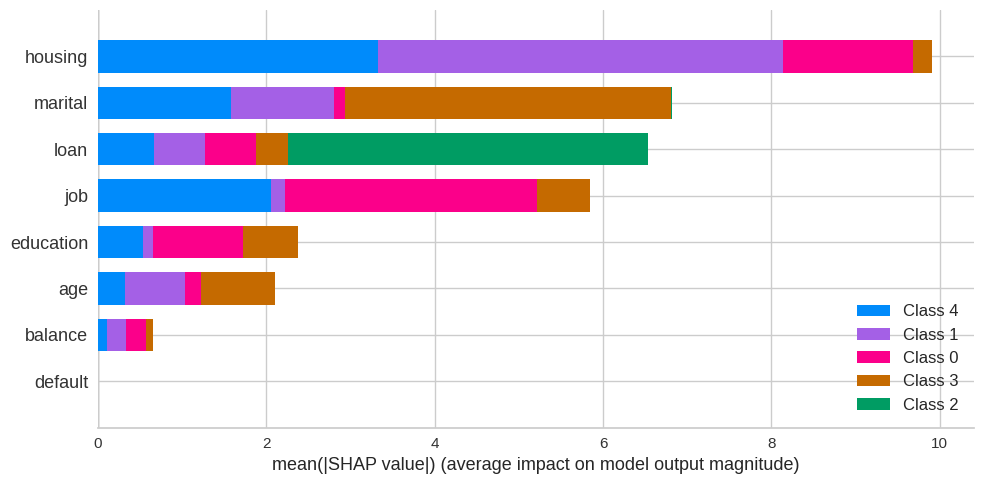

In [17]:
import lightgbm as lgb
import shap

# we create the LGBMClassifier model and train it
clf_km = lgb.LGBMClassifier(colsample_by_tree=0.8)
clf_km.fit(X = data_no_outliers , y = clusters_predict)

#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(data_no_outliers)
shap.summary_plot(shap_values_km, data_no_outliers, plot_type="bar", plot_size=(10, 5))

In [18]:
y_pred = clf_km.predict(data_no_outliers)
accuracy=accuracy_score(y_pred, clusters_predict)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy))
print(classification_report(clusters_predict, y_pred))

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
Training-set accuracy score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8636
           1       1.00      1.00      1.00     10620
           2       1.00      1.00      1.00      5775
           3       1.00      1.00      1.00      8034
           4       1.00      1.00      1.00      7626

    accuracy                           1.00     40691
   macro avg       1.00      1.00      1.00     40691
weighted avg       1.00      1.00      1.00     40691



In [23]:
df_no_outliers = df[data.outliers == 0]
df_no_outliers["cluster"] = clusters_predict

df_no_outliers.groupby('cluster').agg(
    {
        'job': lambda x: x.value_counts().index[0],
        'marital': lambda x: x.value_counts().index[0],
        'education': lambda x: x.value_counts().index[0],
        'housing': lambda x: x.value_counts().index[0],
        'loan': lambda x: x.value_counts().index[0],

        'age':'mean',
        'balance': 'mean',
        'default': lambda x: x.value_counts().index[0],

    }
).reset_index()

<ipython-input-23-80876fde44c3>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



cluster          job  marital  education housing loan        age  \
0        0  blue-collar  married  secondary     yes   no  39.359194   
1        1   management  married  secondary      no   no  46.603861   
2        2  blue-collar  married  secondary     yes  yes  40.676190   
3        3   management   single   tertiary      no   no  32.828728   
4        4   management  married  secondary     yes   no  41.672174   

       balance default  
0   968.908986      no  
1  1441.663936      no  
2   768.815758      no  
3  1195.642893      no  
4  1319.695122      no